# Data Analytics and Classification Exercise
The dataset examined comes from Keggle (https://www.kaggle.com/datasets/jacksondivakarr/phone-classification-dataset/data).
The author collected this dataset from the Internet. It contains a collection of features characterizing mobile phones, including battery power, camera specifications, network support, memory, screen dimensions, and other attributes. The 'price_range' column categorizes phones into price ranges, making this dataset suitable for mobile phone classification and price prediction tasks.

The goal of this exercise is a quick and easy classification model that predicts the 'price_range' column with high accuracy.

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, train_test_split#, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = kagglehub.dataset_download("jacksondivakarr/phone-classification-dataset")

df = pd.read_csv(path + "/train.csv")

In [3]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

The dataset does not contain any missing values or duplicates. The types are also correct for each column.

First, we split the data into a training and a test data set and ensure that each dataset contains approximately the same percentage of examples of each target class as the complete dataset.
We then split the training dataset into an actual training dataset and an evaluation dataset.

In [7]:
seed = 42
x = df.drop("price_range", axis=1)
y = df["price_range"]
x_train_full, x_test, y_train_full, y_test = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=seed, shuffle=True
)
x_train, x_eval, y_train, y_eval = train_test_split(
    x_train_full, y_train_full,
    test_size=0.25,
    stratify=y_train_full,
    shuffle=True
)
print("Train Size:", x_train.shape)
print("Eval Size:", x_eval.shape)
print("Test Size:", x_test.shape)

Train Size: (1200, 20)
Eval Size: (400, 20)
Test Size: (400, 20)


Next, we select several models with multiple parameter sets.

In [8]:
models = {
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    },
    "HistGradientBoosting": {
        "model": HistGradientBoostingClassifier(),
        "params": {
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [None, 5, 10],
            "min_samples_leaf": [20, 50]
        }
    },
    "LogisticRegression": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(max_iter=500))
        ]),
        "params": {
            "logreg__C": [0.1, 1, 10],
            "logreg__penalty": ["l2"]
        }
    },
    "SVC": {
        "model": Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC())
        ]),
        "params": {
            "svc__C": [0.1, 1, 10],
            "svc__kernel": ["rbf", "poly"],
            "svc__gamma": ["scale", "auto"]
        }
    }
}

We then train each model for each set of parameters and select the model with the best parameters for each model.

In [9]:
training_history = []

best_models = {}

for name, mp in models.items():
    print(f"\nTuning: {name}")

    param_grid = list(ParameterGrid(mp["params"]))
    best_acc_eval = 0
    best_model = None
    best_params = None

    for params in param_grid:
        model = mp["model"].set_params(**params)

        model.fit(x_train, y_train)

        acc_train = accuracy_score(y_train, model.predict(x_train))
        acc_eval = accuracy_score(y_eval, model.predict(x_eval))

        history_entry = {"model": name, **params, "acc_train": acc_train, "acc_eval": acc_eval}
        training_history.append(history_entry)

        if acc_eval > best_acc_eval:
            best_acc_eval = acc_eval
            best_model = model
            best_params = params

    best_models[name] = best_model
    print(f"Best eval accuracy: {best_acc_eval:.4f}")
    print(f"Best params: {best_params}")
    
history_df = pd.DataFrame(training_history)


Tuning: RandomForest
Best eval accuracy: 0.8750
Best params: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}

Tuning: HistGradientBoosting
Best eval accuracy: 0.9050
Best params: {'learning_rate': 0.05, 'max_depth': None, 'min_samples_leaf': 20}

Tuning: LogisticRegression
Best eval accuracy: 0.9750
Best params: {'logreg__C': 10, 'logreg__penalty': 'l2'}

Tuning: SVC
Best eval accuracy: 0.8950
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}


After the grid search, we evaluate the best models based on the evaluation data. This gives us the best model with the best parameters.

In [10]:
print("\n================ EVALUATION RESULTS =================\n")

eval_scores = {}

for name, model in best_models.items():
    y_pred_eval = model.predict(x_eval)
    acc_eval = accuracy_score(y_eval, y_pred_eval)
    eval_scores[name] = acc_eval

    print(f"{name}: {acc_eval:.4f}")
    print(classification_report(y_eval, y_pred_eval))
    print("-----------------------------------------------------")

best_model_name = max(eval_scores, key=eval_scores.get)
best_model = best_models[best_model_name]

if hasattr(best_model, "get_params"):
    best_params = best_model.get_params()
else:
    best_params = "N/A"

print(f"\nBest model based on evaluation set: {best_model_name}")
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")


================ EVALUATION RESULTS =================

RandomForest: 0.8750
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       100
           1       0.79      0.84      0.82       100
           2       0.84      0.81      0.82       100
           3       0.95      0.93      0.94       100

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400

-----------------------------------------------------
HistGradientBoosting: 0.8975
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       100
           1       0.84      0.91      0.88       100
           2       0.86      0.88      0.87       100
           3       0.94      0.91      0.92       100

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90  

Finally, we run a test with the best model and the best parameters on the test data set.

In [11]:
print("\n================ FINAL TEST RESULTS =================\n")

y_pred_test = best_model.predict(x_test)
print("Final Test Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


================ FINAL TEST RESULTS =================

Final Test Accuracy: 0.9575
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       100
           1       0.94      0.95      0.95       100
           2       0.95      0.94      0.94       100
           3       0.96      0.98      0.97       100

    accuracy                           0.96       400
   macro avg       0.96      0.96      0.96       400
weighted avg       0.96      0.96      0.96       400



The data frame 'history_df' contains the accuracy of the evaluation for each model and parameter set. This allows us to create some plots.

In [12]:
history_df.head()

,model,max_depth,min_samples_split,n_estimators,acc_train,acc_eval,learning_rate,min_samples_leaf,logreg__C,logreg__penalty,svc__C,svc__gamma,svc__kernel
0,RandomForest,NaN,2.0,100.0,1.000000,0.8675,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RandomForest,NaN,2.0,200.0,1.000000,0.8625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RandomForest,NaN,5.0,100.0,1.000000,0.8700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RandomForest,NaN,5.0,200.0,1.000000,0.8600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RandomForest,10.0,2.0,100.0,0.999167,0.8600,NaN,NaN,NaN,NaN,NaN,NaN,NaN


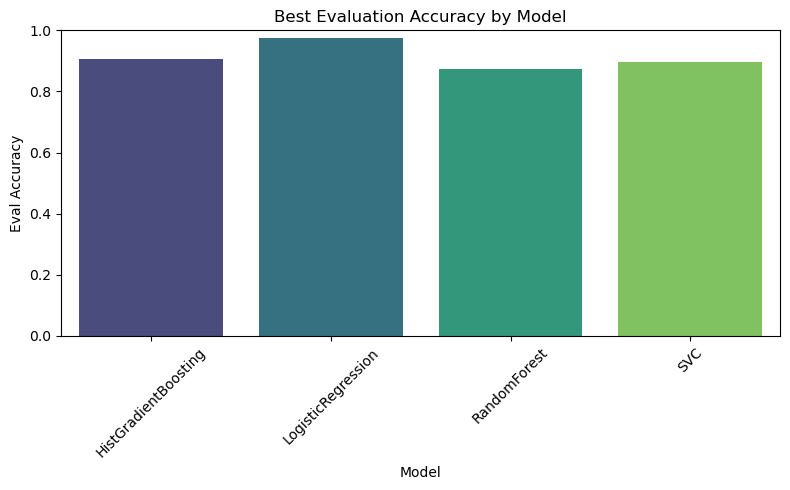

In [13]:
best_eval_per_model = history_df.groupby("model")["acc_eval"].max().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=best_eval_per_model, x="model", y="acc_eval", palette="viridis", hue="model")
plt.title("Best Evaluation Accuracy by Model")
plt.ylabel("Eval Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

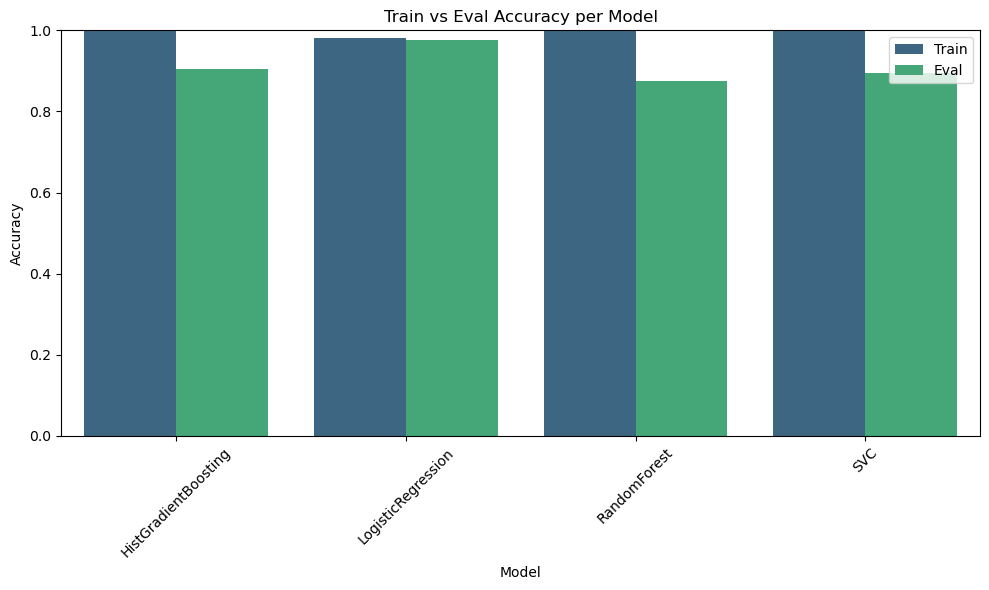

In [14]:
best_train = history_df.groupby("model")["acc_train"].max().reset_index()
best_train = best_train.rename(columns={"acc_train": "Accuracy"})
best_train["Type"] = "Train"

best_eval = history_df.groupby("model")["acc_eval"].max().reset_index()
best_eval = best_eval.rename(columns={"acc_eval": "Accuracy"})
best_eval["Type"] = "Eval"

df_plot = pd.concat([best_train, best_eval], axis=0)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x="model", y="Accuracy", hue="Type", palette="viridis")
plt.title("Train vs Eval Accuracy per Model")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()
plt.show()

Comparing training accuracy and evaluation accuracy is an indicator for detecting overfitting. If the training accuracy is significantly higher, it could be a case of overfitting.
Some parameters should be changed, some models learn the training data and do not perform as well on the evaluation data. For example, RandomForest may have too many trees (n_estimator).

In [15]:
def plot_accuracy_vs_param(history_df, model_name, param_name):
    """
    Plots training and evaluation accuracy vs a single hyperparameter for a given model.

    Parameters:
    - history_df (pd.DataFrame): DataFrame containing training history
      (must include columns: 'model', param columns, 'acc_train', 'acc_eval')
    - model_name (str): Name of the model to plot
    - param_name (str): Hyperparameter to plot on the x-axis
    """
    df_model = history_df[history_df["model"] == model_name]

    if param_name not in df_model.columns:
        raise ValueError(f"Parameter '{param_name}' not found in history_df columns")

    plt.figure(figsize=(8, 5))
    sns.lineplot(data=df_model, x=param_name, y="acc_train", marker="o", label="Train Accuracy")
    sns.lineplot(data=df_model, x=param_name, y="acc_eval", marker="o", label="Eval Accuracy")

    plt.title(f"Accuracy vs {param_name} for {model_name}")
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

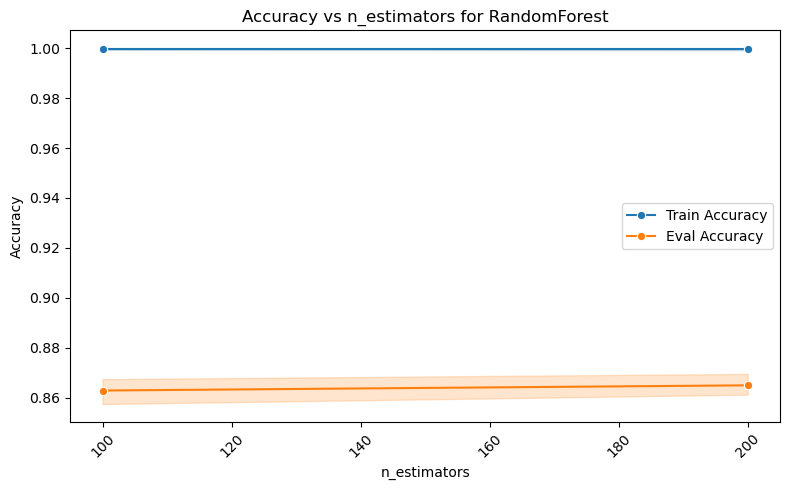

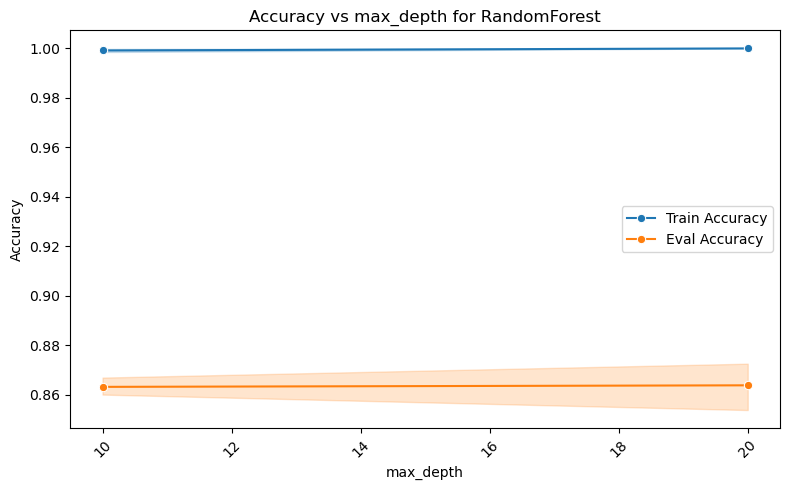

In [16]:
plot_accuracy_vs_param(history_df, "RandomForest", "n_estimators")
plot_accuracy_vs_param(history_df, "RandomForest", "max_depth")

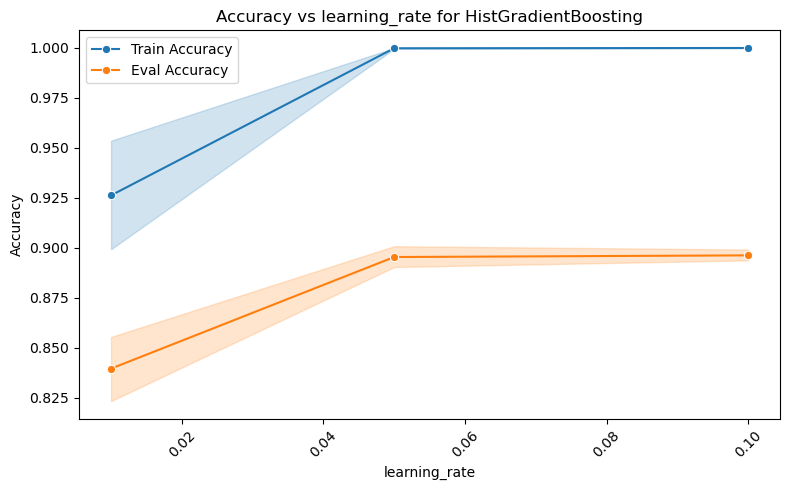

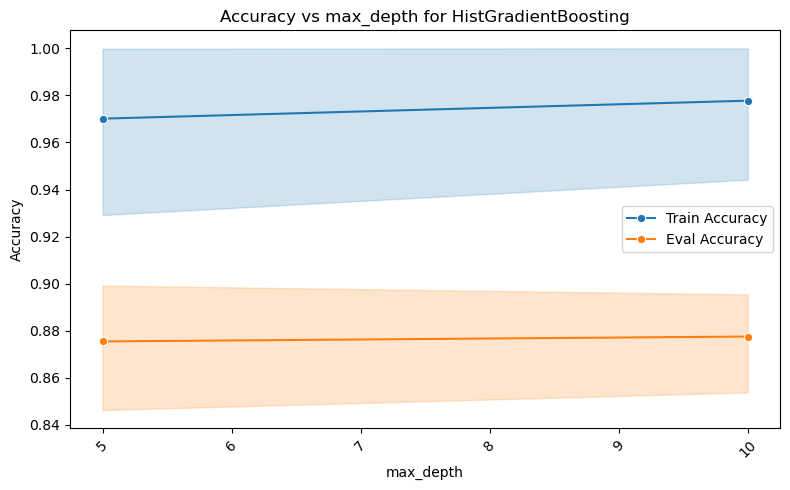

In [17]:
plot_accuracy_vs_param(history_df, "HistGradientBoosting", "learning_rate")
plot_accuracy_vs_param(history_df, "HistGradientBoosting", "max_depth")

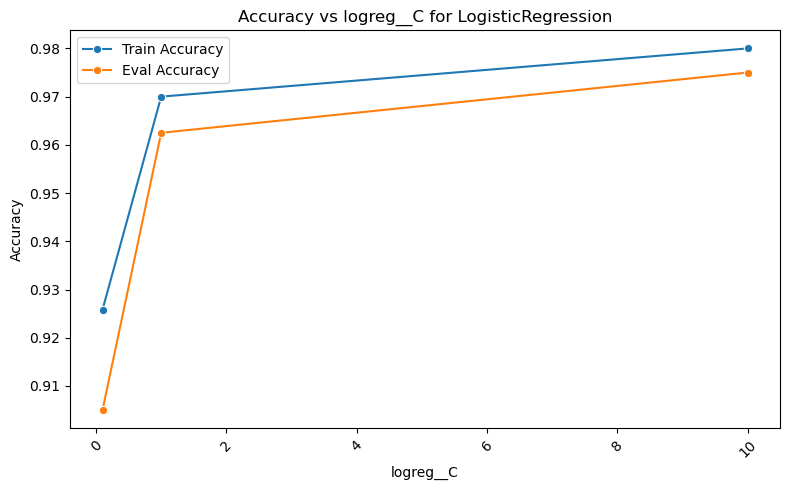

In [18]:
plot_accuracy_vs_param(history_df, model_name="LogisticRegression", param_name="logreg__C")

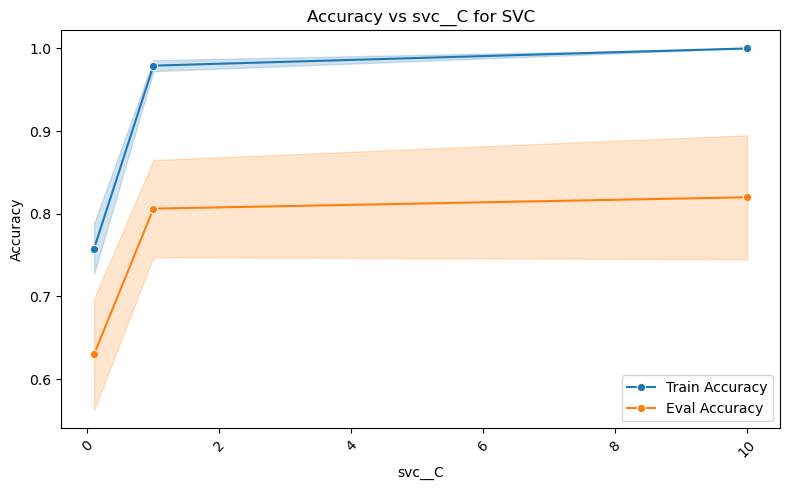

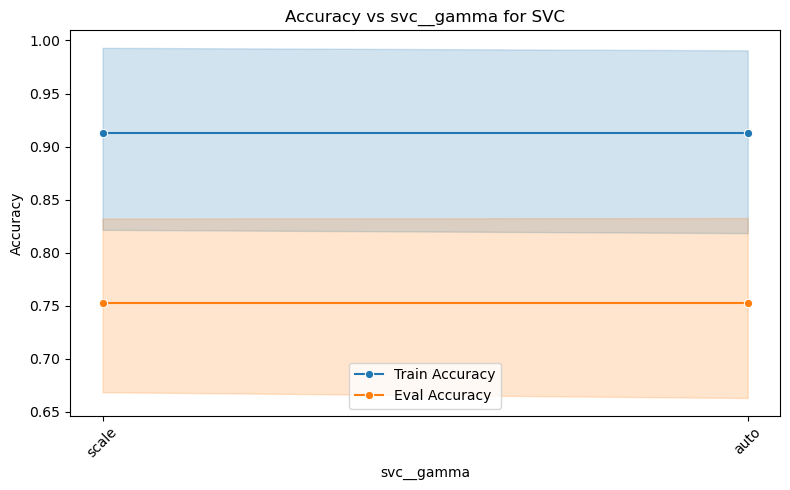

In [19]:
plot_accuracy_vs_param(history_df, "SVC", "svc__C")
plot_accuracy_vs_param(history_df, "SVC", "svc__gamma")

The best model for multiple seeds is 'LogisticRegression', which achieves really good scores. There is no need to use more complex models such as those from PyTorch.